<a href="https://colab.research.google.com/github/JackBstn/NLP/blob/main/chronos_multivariate_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chronos adaptation to Multivariate Input: Preprocessing Multivariate Time Series

This notebook is designed to explore preprocessing techniques that transform multivariate time series data into univariate formats suitable for analysis with Chronos. It focuses on two primary preprocessing methods:
1. **Simple Transformation Methods**: Aggregating multiple variables into a single representative feature (Weighted Sum, Arithmetic Mean, PCA).
2. **Machine Learning-Based Methods**: Employ machine learning models to capture the underlying relationships among variables (Linear Regression, Random Forest, Support Vector Regression).

In this notebook, we apply these techniques to Apple stock market data, where the goal is to predict the Close price. The dataset includes multiple financial indicators (Open, High, Low, Volume, Close), and our preprocessing steps will transform these multivariate inputs into a univariate format, enabling the application of Chronos for forecasting. For comparison, we also evaluate Chronos using only the historical values of the Close price as input, without any transformation from multivariate data. This allows us to determine whether incorporating additional variables enhances forecasting performance.

The evaluation includes calculating various metrics such as MSE, RMSE, MAPE, and MASE,
and visualizing the forecast results to compare the performance of the fine-tuned model against the zero-shot model.

#### Install Dependencies

In [50]:
!pip install torch transformers chronos yfinance pandas matplotlib
!pip install git+https://github.com/amazon-science/chronos-forecasting.git

  Cloning https://github.com/amazon-science/chronos-forecasting.git to /tmp/pip-req-build-x9up58f0
  Running command git clone --filter=blob:none --quiet https://github.com/amazon-science/chronos-forecasting.git /tmp/pip-req-build-x9up58f0
  Resolved https://github.com/amazon-science/chronos-forecasting.git to commit 73d6c9aa1aba42612d99f13fc9365ff7f39c4335
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [51]:
import pandas as pd
import yfinance as yf
import torch
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from chronos import BaseChronosPipeline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gmean
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR


seed = 343124

def reset_seed():
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

### Utils

In [52]:
# Function to compute MASE
def mase(y_true, y_pred, y_train):
    naive_forecast = np.abs(np.diff(y_train)).mean()  # Naive benchmark
    return np.mean(np.abs(y_true - y_pred)) / naive_forecast

# Function to compute evaluation metrics
def compute_metrics(y_true, y_pred, y_train):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    mase_score = mase(y_true, y_pred, y_train)
    return { "MSE": mse, "RMSE": rmse, "MAPE": mape, "MASE": mase_score }

# Function to compute the relative score
def agg_relative_score(model_df: pd.DataFrame, baseline_df: pd.DataFrame):
    relative_score = model_df / baseline_df  # Ratio between model and baseline
    return relative_score.agg(gmean)  # Geometric mean of improvements

### Download data and Chronos model

In [53]:
reset_seed()  # For reproducibility

# Download data from Yahoo Finance (AAPL)
symbol = "AAPL"
data = yf.download(symbol, start="2023-09-01", end="2023-12-31", progress=False)
data_to_predict = yf.download(symbol, start="2024-01-01", end="2024-02-15", progress=False)
all_close_values = np.concatenate([data['Close'].values, data_to_predict['Close'].values])

# Standardize data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[['Open', 'High', 'Low', 'Close', 'Volume']])

# Chronos model
pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-t5-tiny",
    device_map="cuda",  # Usa "cpu" se non hai una GPU disponibile
    torch_dtype=torch.bfloat16,
)

## Pre-processing (from multivariate to univariate) using simple methods

Define the aggregation methods:

In [54]:
reset_seed()  # For reproducibility

# Function to calculate PCA
def calculate_pca(data, scaler):
    pca = PCA(n_components=1)
    aapl_pca = pca.fit_transform(data)
    explained_variance = pca.explained_variance_ratio_[0]
    print(f"Explained Variance Ratio of the first component: {explained_variance}")
    return aapl_pca.flatten() * np.sqrt(pca.explained_variance_[0]) + scaler.mean_[3]  # Shift by Close mean

# Solution 1: Weighted Mean (Open, High, Low, Close)
weights = {'Open': 0.2, 'High': 0.3, 'Low': 0.3, 'Close': 0.2}
aapl_combined = (data['Open'] * weights['Open'] +
                 data['High'] * weights['High'] +
                 data['Low'] * weights['Low'] +
                 data['Close'] * weights['Close'])

# Solution 2: Arithmetic Mean (Open, High, Low, Close)
aapl_mean = data[['Open', 'High', 'Low', 'Close']].mean(axis=1)

# Solution 3: Principal Component Analysis (PCA)
aapl_pca_rescaled = calculate_pca(scaled_data, scaler)
aapl_pca_series = pd.Series(aapl_pca_rescaled, index=data.index)

Explained Variance Ratio of the first component: 0.8085689754835905


Chronos prediction using:
1. Only Close prices
2. Univariate data obtained from simple aggregation methods on multivariate data

Weighted Mean
Variance: [ 298.40695  387.6596   541.73773  875.07666 1062.171   1217.5038
 1371.1302  1641.3073  2085.075   2553.8687  3035.9478  3280.3438
 2992.5974  3055.9683  2999.5947  3132.0168  3450.0312  3959.7363
 3998.5613  4010.2585  4116.8228  4377.3037  4661.29    5157.1865
 5566.773   5657.233   5803.064   6190.0063  6371.367   6439.7393 ]


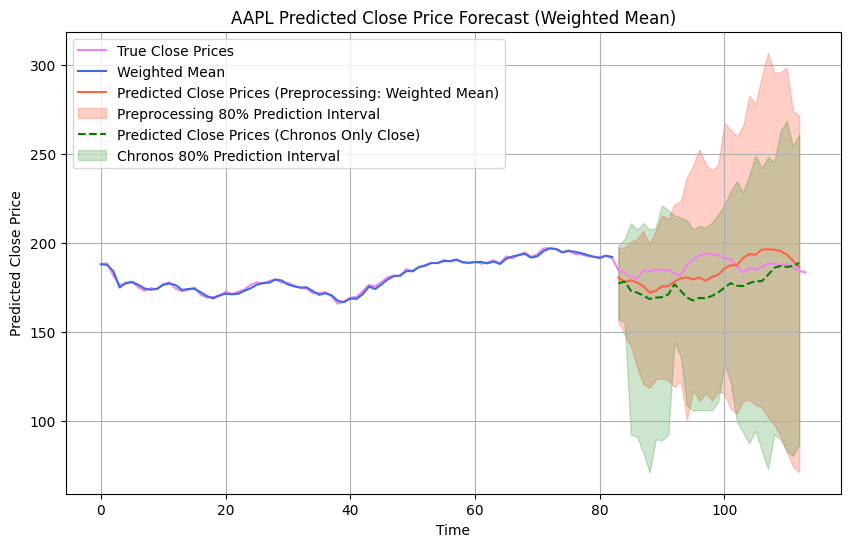

Arithmetic Mean
Variance: [  1.7026364   2.6426272   5.6931496  10.690157   16.866585   24.900814
  35.5599     41.430363   41.58555    47.402794   43.91334    45.45188
  44.44538    44.139435   56.660797   58.899902   70.14426    80.80332
  88.93947    91.97675    90.53573    98.48133    91.959045   89.9372
  94.51297   100.38344   106.4135    162.32944   256.70502   295.63013  ]


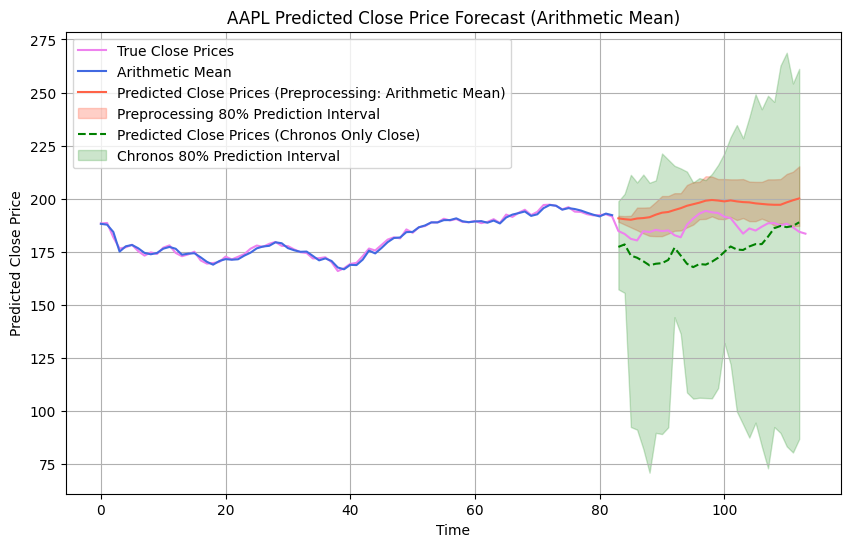

PCA
Variance: [ 0.9057261  1.043361   1.3985476  1.6160996  1.8469709  2.1488798
  2.6639004  3.1034436  3.9914105  4.599668   4.954854   5.021453
  6.264606  10.988602   9.483493  12.165154  12.768986  13.958858
 14.029902  10.478017  13.301761  10.739966  11.237229  11.081835
 14.611514  17.310946  16.58725   15.357419  16.565054  17.670582 ]


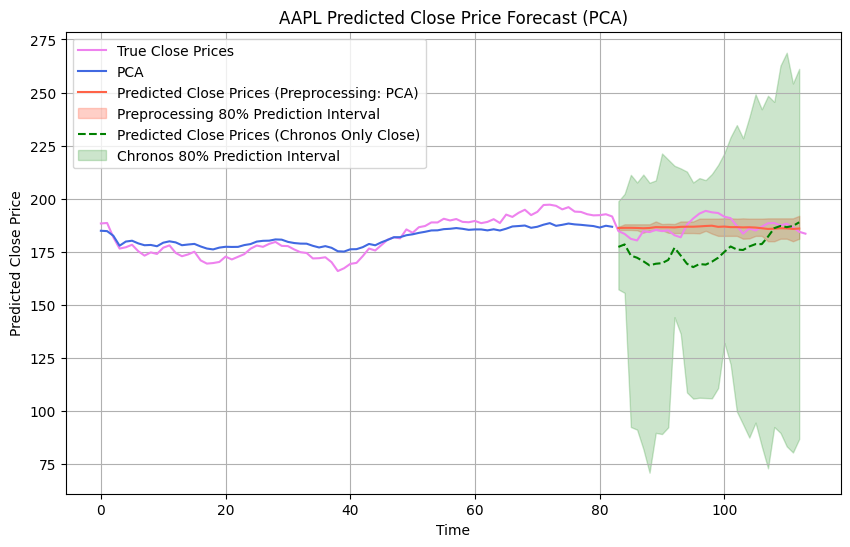

PERFORMANCE METRICS:
                           MSE       RMSE      MAPE      MASE
Chronos Only Close  179.450643  13.395919  6.175695  7.268400
Weighted Mean        67.783963   8.233102  4.032297  5.397710
Arithmetic Mean      93.314841   9.659961  5.069192  6.773082
PCA                  12.773195   3.573961  1.617844  4.329501
-------------------------------------------------
SCALING PERFORMANCE (Preprocessing vs Chronos Only Close):
MSE     0.240906
RMSE    0.490822
MAPE    0.519745
MASE    0.744228
dtype: float64


In [55]:
reset_seed()  # For reproducibility

# Dictionary to store metrics
results = {}

# Chronos prediction using only Close prices
forecast_close = pipeline.predict(
    context=torch.tensor(data['Close'].values), prediction_length=30
)

# Extract forecast statistics
forecast_index_close = range(len(data['Close']), len(data['Close']) + 30)
low_close, median_close, high_close = np.quantile(forecast_close[0].numpy(), [0.1, 0.5, 0.9], axis=0)
mean_forecast_close = np.mean(forecast_close[0].numpy(), axis=0)

# Compute metrics for Chronos (Close-only)
actual_values = data_to_predict['Close'].values[:30] # True values for comparison
results["Chronos Only Close"] = compute_metrics(actual_values, mean_forecast_close, data['Close'].values.reshape(-1))

# Chronos prediction using preprocessing methods
methods = {
    "Weighted Mean": aapl_combined,
    "Arithmetic Mean": aapl_mean,
    "PCA": aapl_pca_series
}

for title, close_prices in methods.items():
    # Step 1: Chronos prediction
    forecast = pipeline.predict(
        context=torch.tensor(close_prices.values), prediction_length=30
    )

    forecast_index = range(len(close_prices), len(close_prices) + 30)
    low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)
    mean_forecast = np.mean(forecast[0].numpy(), axis=0)
    variance_forecast = np.var(forecast[0].numpy(), axis=0)

    # Step 2: Compute metrics
    results[title] = compute_metrics(actual_values, mean_forecast, close_prices.values.reshape(-1))

    # Step 3: Visualization
    print(f"{title}")
    print(f'Variance: {variance_forecast}')

    plt.figure(figsize=(10, 6))
    plt.plot(all_close_values, color="violet", label="True Close Prices")  # True Close Prices
    plt.plot(close_prices.values, color="royalblue", label=f"{title}")  # Close Prices using preprocessing methods

    # Predicted Close Prices using preprocessing methods
    plt.plot(forecast_index, mean_forecast, color="tomato", label=f"Predicted Close Prices (Preprocessing: {title})")
    plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="Preprocessing 80% Prediction Interval")

    # Add Chronos-only Close prediction
    plt.plot(forecast_index_close, mean_forecast_close, color="green", linestyle="dashed",
            label="Predicted Close Prices (Chronos Only Close)")
    plt.fill_between(forecast_index_close, low_close, high_close, color="green", alpha=0.2, label="Chronos 80% Prediction Interval")

    plt.title(f"{symbol} Predicted Close Price Forecast ({title})")
    plt.xlabel("Time")
    plt.ylabel("Predicted Close Price")
    plt.legend()
    plt.grid()
    plt.savefig(f"{title.replace(' ', '_')}.png")
    plt.show()


# Convert results to DataFrame
results_df = pd.DataFrame(results).T
print("PERFORMANCE METRICS:")
print(results_df)

# Compute relative performance
relative_scores = agg_relative_score(results_df.iloc[1:], results_df.iloc[0])  # Exclude Chronos Only Close as baseline
print("-------------------------------------------------")
print("SCALING PERFORMANCE (Preprocessing vs Chronos Only Close):")
print(relative_scores)

## Pre-processing (from multivariate to univariate) using ML methods

Preprocessing to scale data:

In [56]:
reset_seed()  # For reproducibility

# Data preprocessing
scaler = StandardScaler()
X = data[['Open', 'High', 'Low', 'Volume']].values
y = data['Close'].values
X_scaled = scaler.fit_transform(X)

Define the ML methods:

In [57]:
# ML methods for regression
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=seed),
    "Support Vector Regression": SVR(kernel='rbf')
}

Chronos prediction using:
1. Only Close prices
2. Univariate data obtained from ML methods on multivariate data

Linear Regression Variance: [ 297.4118   386.36664  539.93097  872.158   1058.6287  1213.4432
 1366.5574  1635.8336  2078.1208  2545.3513  3025.8225  3269.4023
 2982.6165  3045.776   2989.5903  3121.571   3438.525   3946.5298
 3985.2253  3996.8835  4103.093   4362.704   4645.743   5139.9854
 5548.207   5638.365   5783.71    6169.3604  6350.118   6418.2617 ]


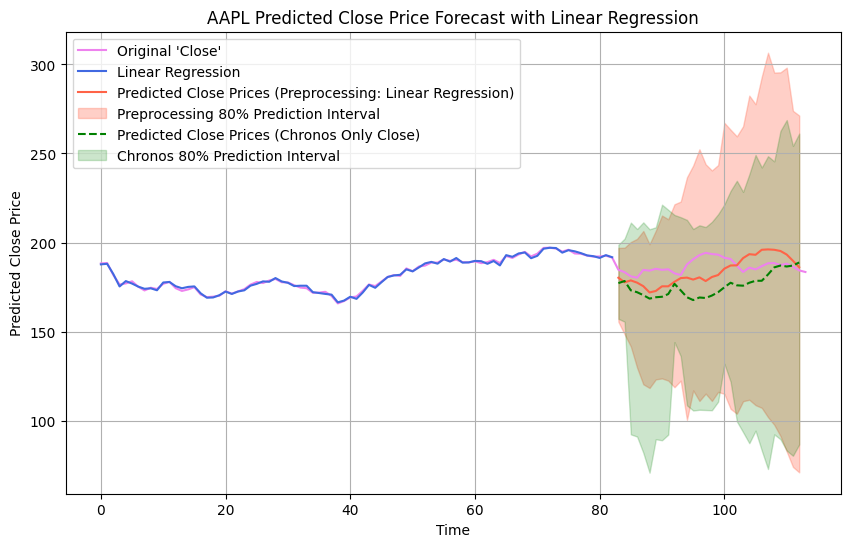

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Random Forest Variance: [  1.7054856   2.647049    5.7026844   8.576233   11.880598   18.38717
  27.962673   32.737095   31.16042    34.091667   35.95705    43.787117
  46.98486    59.0875     53.93554    58.8743     58.70998    53.984413
  81.16533   102.221695  107.031654  115.01272   112.259094  113.960106
 116.58943   121.954544  141.76743   186.1097    279.00012   314.17548  ]


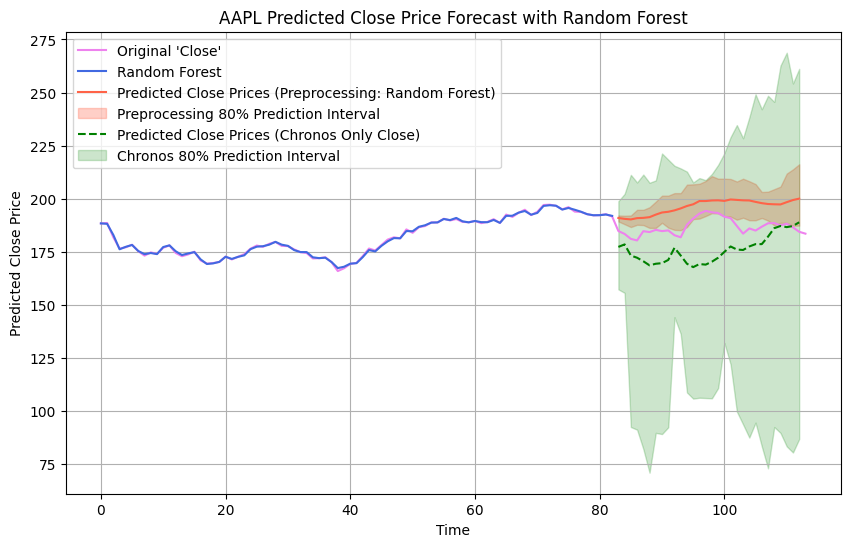

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Support Vector Regression Variance: [  3.4571686   3.2796524   3.2663407   5.5518675   9.124385   19.864124
  22.349356   18.444      15.670313   16.935118   19.7532     25.078697
  32.74741    43.65135    59.51687    73.31441    60.972523   60.55091
  61.403004   53.432503   40.274117   50.343742   64.6649     67.68267
  83.716866   87.42252    98.184456   94.2791    106.58099   108.5115   ]


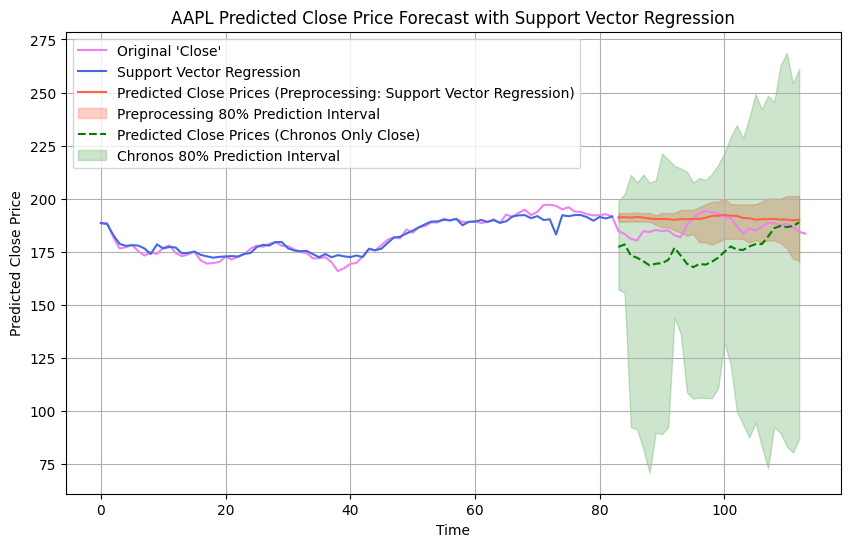

PERFORMANCE METRICS (ML Models):
                                  MSE       RMSE      MAPE      MASE
Chronos Only Close         179.450643  13.395919  6.175695  7.268400
Linear Regression           69.347812   8.327533  4.071676  4.408768
Random Forest               97.555268   9.877007  5.169146  7.037651
Support Vector Regression   28.431498   5.332119  2.583781  3.509989
-------------------------------------------------
SCALING PERFORMANCE (ML Models vs Chronos Only Close):
MSE     0.321674
RMSE    0.567163
MAPE    0.613475
MASE    0.657019
dtype: float64


In [58]:
reset_seed()  # For reproducibility

# Dictionary to store metrics for ML models
ml_results = {}

# Chronos prediction using only Close prices
forecast_close = pipeline.predict(
    context=torch.tensor(data['Close'].values), prediction_length=30
)

# Extract forecast statistics
forecast_index_close = range(len(data['Close']), len(data['Close']) + 30)
low_close, median_close, high_close = np.quantile(forecast_close[0].numpy(), [0.1, 0.5, 0.9], axis=0)
mean_forecast_close = np.mean(forecast_close[0].numpy(), axis=0)

# Compute metrics for Chronos (Close-only)
actual_values = data_to_predict['Close'].values[:30] # True values for comparison
ml_results["Chronos Only Close"] = compute_metrics(actual_values, mean_forecast_close, data['Close'].values.reshape(-1))


for model_name, model in models.items():
    # Step 1: Fit the model
    model.fit(X_scaled, y)

    # Previsione dei valori di Close
    predicted_close = model.predict(X_scaled)

    # Step 2: Forecasting con Chronos
    forecast = pipeline.predict(
        context=torch.tensor(predicted_close), prediction_length=30
    )

    # Extract forecast statistics
    forecast_index = range(len(predicted_close), len(predicted_close) + 30)
    low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)
    mean_forecast = np.mean(forecast[0].numpy(), axis=0)
    variance_forecast = np.var(forecast[0].numpy(), axis=0)

    # Store metrics in the results dictionary
    actual_values = data_to_predict['Close'].values[:30]  # True values for comparison
    ml_results[model_name] = compute_metrics(actual_values, mean_forecast, predicted_close.reshape(-1))

    print(f"{model_name} Variance: {variance_forecast}")

    # Step 3: Visualization
    plt.figure(figsize=(10, 6))
    plt.plot(all_close_values, color="violet", label="Original 'Close'")  # Original Close Prices
    plt.plot(predicted_close, color="royalblue", label=f"{model_name}")  # Predicted Close

    # Predicted Close Prices using Chronos forecast
    plt.plot(forecast_index, mean_forecast, color="tomato", label=f"Predicted Close Prices (Preprocessing: {model_name})")
    plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="Preprocessing 80% Prediction Interval")

    # Add Chronos-only Close prediction
    plt.plot(forecast_index_close, mean_forecast_close, color="green", linestyle="dashed",
            label="Predicted Close Prices (Chronos Only Close)")
    plt.fill_between(forecast_index_close, low_close, high_close, color="green", alpha=0.2, label="Chronos 80% Prediction Interval")

    plt.title(f"{symbol} Predicted Close Price Forecast with {model_name}")
    plt.xlabel("Time")
    plt.ylabel("Predicted Close Price")
    plt.legend()
    plt.grid()
    plt.savefig(f"{model_name.replace(' ', '_')}.png")
    plt.show()

# Convert results for ML models to DataFrame
ml_results_df = pd.DataFrame(ml_results).T
print("PERFORMANCE METRICS (ML Models):")
print(ml_results_df)

# Compute relative performance for ML models
relative_scores_ml = agg_relative_score(ml_results_df.iloc[1:], ml_results_df.iloc[0])  # Exclude Chronos Only Close as baseline
print("-------------------------------------------------")
print("SCALING PERFORMANCE (ML Models vs Chronos Only Close):")
print(relative_scores_ml)
